<a href="https://colab.research.google.com/github/Nell87/drivendata_richter/blob/main/script/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Overview**
# **Automatic EDA**
# **Manual EDA**
## **Location features**

# **Overview** 
Based on aspects of building location and construction, **our goal is to predict the level of damage to buildings** caused by the 2015 Gorkha earthquake in Nepal.

The data was collected through surveys by Kathmandu Living Labs and the Central Bureau of Statistics, which works under the National Planning Commission Secretariat of Nepal. This survey is one of the largest post-disaster datasets ever collected, containing valuable information on earthquake impacts, household conditions, and socio-economic-demographic statistics.

In [2]:
####    INCLUDES  _______________________________________ #### 
#Loading Libraries:# 
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

####    READING TRAIN AND TEST DATA _______________________________________ #### 
train_values = data = pd.read_csv("https://raw.githubusercontent.com/Nell87/drivendata_richter/main/data/train_values.csv")
train_labels = pd.read_csv("https://raw.githubusercontent.com/Nell87/drivendata_richter/main/data/train_labels.csv")
test_values = pd.read_csv("https://raw.githubusercontent.com/Nell87/drivendata_richter/main/data/test_values.csv")
train_merge = train_values.merge(train_labels, on = 'building_id', how = 'inner',)
print(train_merge.shape)

(260601, 40)


# **Automatic EDA**
An useful Python module to quickly do an exploratory analysis is "Pandas Profiling". With just a few lines of code you obtain an interactive report with an overview and alerts. 

In this report we can confirm that there aren't missing values or duplicates. 

```
# Install the python module
pip install pandas_profiling

# Import Pandas Profiling
from pandas_profiling import ProfileReport

# Generate the report
profile = ProfileReport(train_merge, title="Profiling Report")

# Export the report to html file
profile.to_file("Profiling Report.html")
```

![](https://drive.google.com/uc?export=view&id=1QW5kZvHvB_kogLVbw1fqudesqpWO57SR)

# **Manual EDA**
After generating the automatic EDA, let's manually analyze interesting features that could have an impact when building our model. 

The dataset has information about the building structure, use cases, area, location, age and legal ownership. Each row represents a specific building in the region that was hit by Gorkha earthquake.The train dataset has 260,601 rows and the test dataset has 86,868 rows. Both have 38 features to predict the level of damage to every building (the damage_grade feature).

In [2]:
train_merge.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

## **Manual EDA: Target feature or damage_grade**
Almost 60% of the buildings suffer a medium amount of damage, followed by high with around 30% and low with around 10%. Therefore, we deal with imbalanced data. It makes sense since the earthquake had a strong magnitude, 7.8,  in a country where the buildings are more prone to be weak in structure. In a richer country, like Japan or California, earquakes of this magnitude is not usually a giant disaster.

In [3]:
train_merge['damage_grade'].value_counts(normalize=True) * 100     # High 33.46, Medium 56.90, Low 9.64


2    56.891186
3    33.468022
1     9.640792
Name: damage_grade, dtype: float64

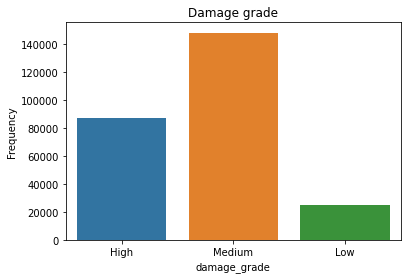

In [4]:
# Add labels
damage_map = {1:"Low", 2:"Medium", 3:"High"}
train_merge["damage_grade"] = train_merge["damage_grade"].map(damage_map)

sns.countplot(x="damage_grade", data=train_merge)
plt.title("Damage grade")
plt.ylabel('Frequency')
plt.show()

## **Manual EDA: Location features**
The features **geo_level_1_id, geo_level_2_id, geo_level_3_id** represent the geographic region in which building exists, from largest (level 1) to most specific sub-region (level 3). Possible values: level 1: 0-30, level 2: 0-1427, level 3: 0-12567.

For every location feature there is a high number of categorical values, so we'll apply feature engineering on them. We'll replace every value with their conditional probabilities respect to every damage_grade category. 

In [44]:
def categoricalvalues_condprob(data, index, columns, new_column_name):
  # Create prob table
  probs = data.groupby(index).size().div(len(data))
  probs_group = data.groupby([index, columns]).size().div(len(data)).div(probs, axis=0, level=index).reset_index()
  probs_group.columns= [index, columns, new_column_name]
  probs_group_wide = probs_group.pivot(index=[index], columns = columns,values = new_column_name) #Reshape from long to wide
  probs_group_wide = probs_group.reset_index(drop=True)

  # Add column to main dataset
  data_merge = data.merge(probs_group_wide, on=[index,columns ], how='left')

  # Return dataset
  return data_merge

test = categoricalvalues_condprob(train_merge, 'geo_level_1_id', 'damage_grade', 'prob_cond_geo_level_1')
test = categoricalvalues_condprob(test, 'geo_level_2_id', 'damage_grade', 'prob_cond_geo_level_2')
test = categoricalvalues_condprob(test, 'geo_level_3_id', 'damage_grade', 'prob_cond_geo_level_3')

test

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,prob_cond_geo_level_1,prob_cond_geo_level_2,prob_cond_geo_level_3
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,High,0.248185,0.744444,0.837838
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,Medium,0.446174,0.492462,0.812500
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,High,0.584996,0.601136,0.610294
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,Medium,0.739603,0.853659,0.838710
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,High,0.384672,0.378613,0.377049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,n,r,...,0,0,0,0,0,0,Medium,0.779516,0.724138,0.928571
260597,669485,17,715,2060,2,0,6,5,t,r,...,0,0,0,0,0,0,High,0.807546,0.934866,0.979592
260598,602512,17,51,8163,3,55,6,7,t,r,...,0,0,0,0,0,0,High,0.807546,0.918919,0.863636
260599,151409,26,39,1851,2,10,14,6,t,r,...,0,0,0,0,0,0,Medium,0.559142,0.452947,0.766949


## **Manual EDA: Materials used features**


## **Manual EDA: Others features**
